Let's take all the results from the Severn Bridge Half and do some analysis! This is an example of basic scraping and data analysis.

In [37]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [5]:
# for parsing HTML page
import requests
from bs4 import BeautifulSoup
from datetime import time, timedelta, datetime
# for easy import/export
# import json
# for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from pprint import pprint

In [6]:
pd.__version__, requests.__version__, np.__version__, mpl.__version__

('0.16.2', '2.7.0', '1.9.2', '1.4.3')

In [7]:
import seaborn as sns
print sns.__version__
sns.set_style("whitegrid")

0.6.0


In [8]:
%matplotlib inline
get_ipython().magic(u'load_ext autoreload')
get_ipython().magic(u'autoreload 2')
mpl.rcParams['figure.figsize'] = (14.0, 6.0)  # default size of plots
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
# mpl.rcParams['xtick.major.size'] = 10
# mpl.rcParams['ytick.major.size'] = 10
# mpl.rcParams['xtick.minor.size'] = 5
# mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.9
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['legend.scatterpoints'] = 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Scraping the data 

First, we need to scrape the table of results from the website. Let's use `requests` to pull the result data, and use the JSON decoder. We also need the column headers from the HTML.

In [9]:
# Get the table of restuls via a POST request
# page = requests.get(r"https://www.fullonsport.com/event/5834/results")
page = requests.get(r'https://www.fullonsport.com/event/5834/admin/getResultParticipants/')

In [10]:
# What does a record look like?
print page.json()['data'][0]

[u'164', u'2741', u'Andrew', u'Dickens', None, u'Pont-y-pwl runners', u'1', u'M45+', u'17', u'01:35:03', u'01:35:00', u'RES']


In [11]:
# Make an offline copy of the JSON data
# import json
# with open('results_dump.json', 'w') as outfile:
#     json.dump(page.json(), outfile, indent=4)

In [12]:
# Get the table column names
webpage = requests.get(r"https://www.fullonsport.com/event/5834/results")
soup = BeautifulSoup(webpage.text, 'lxml')  # lxml parser
raw_table = soup.find(id='participant-table')
columns = [str(x.string) for x in raw_table.find('thead').findAll('th')]
print 'Columns:', columns

Columns: ['Position', 'Race No', 'Firstname', 'Lastname', 'Team', 'Club', 'Club Pos', 'Category', 'Cat Pos', 'Time', 'Chip Time', 'Status']


In [13]:
# Make a class to hold the runner info

class Runner(object):
    """Class to describe entry."""
    def __init__(self, gun_position, race_num, firstname, surname, club, club_pos, 
                 category, category_pos, gun_time, chip_time, status):
        self.gun_position = int(gun_position) # based off gun time
        self.race_num = int(race_num)
        self.name = "%s %s" % (firstname, surname)
        self.category = category
        fmt = '%H:%M:%S'
        # Gun time is the time difference between the gun firing and the runner's finish
        # incase there is a missing entry
        self.gun_datetime = gun_time
#         self.gun_datetime = datetime.strptime(gun_time, fmt) if gun_time else datetime.max  
#         self.gun_time = self.gun_datetime.time()
        # Chip time is the time difference between when runner crossing the start and finish lines
        self.chip_datetime = chip_time
#         self.chip_datetime = datetime.strptime(chip_time, fmt) if chip_time else datetime.max
#         self.chip_time = self.chip_datetime.time()
#         self.gun_chip_delta = self.gun_datetime - self.chip_datetime # difference between gun time and chip time
        self.status = status

In [14]:
# Let's get all the rows!
runner_table = []
for entry in page.json()['data']:
    row = {k: v for k, v in zip(columns, entry)}
#     print row
    runner = Runner(gun_position=row['Position'], race_num=row['Race No'], 
                    firstname=row['Firstname'], surname=row['Lastname'], 
                    club=row['Club'], club_pos=row['Club Pos'], 
                    category=row['Category'], category_pos=row['Cat Pos'], 
                    gun_time=row['Time'], chip_time=row['Chip Time'], 
                    status=row['Status'])
    runner_table.append(runner)
    

In [40]:
print runner_table[0].name
runner_table[0].__dict__

Andrew Dickens


{'category': u'M45+',
 'chip_datetime': u'01:35:00',
 'gun_datetime': u'01:35:03',
 'gun_position': 164,
 'name': u'Andrew Dickens',
 'race_num': 2741,
 'status': u'RES'}

# Analysis - making the DataFrame

So now we have all the data in the table in our objects, stored in the list `runner_table`. This isn't very convenient for analysis though - let's uses a `pandas` DataFrame instead!

In [16]:
df = pd.DataFrame(data=[x.__dict__ for x in runner_table], 
                  columns=runner_table[0].__dict__.keys())
df = df[df.chip_datetime != '']
df = df.dropna()
print df.columns
df.head()

Index([u'category', u'status', u'name', u'gun_position', u'gun_datetime',
       u'chip_datetime', u'race_num'],
      dtype='object')


,category,status,name,gun_position,gun_datetime,chip_datetime,race_num
0,M45+,RES,Andrew Dickens,164,01:35:03,01:35:00,2741
1,M45+,RES,Steve McCoy,1533,02:11:44,02:09:20,2764
2,F35+,RES,Rhian Rogers,1023,01:58:41,01:57:39,2777
3,M40+,RES,Keith Shevlan,2077,02:34:33,02:32:13,2173
4,Male Senior,RES,Sean parry,1003,01:58:13,01:55:59,1826


In [17]:
df.tail()

,category,status,name,gun_position,gun_datetime,chip_datetime,race_num
2301,Male Senior,RES,andrew meadows,1412,02:08:07,02:05:42,2765
2302,Male Senior,RES,Gavin Ellis,658,01:50:06,01:48:36,2743
2303,M40+,RES,eric quijana,1026,01:58:47,01:54:45,2771
2304,F50+,RES,Carolyn Thomas,647,01:49:53,01:44:59,2787
2305,F45+,RES,Pam Bland,2175,02:43:11,02:38:54,2728


In [18]:
num_runners = len(df.index)
print num_runners, 'runners'

2303 runners


We need to convert all the time elements to the correct type of object.

In [19]:
time_converter = np.vectorize(lambda x : pd.to_datetime(x, format='%H:%M:%S'))
df.chip_datetime = df.chip_datetime.apply(time_converter)
df.gun_datetime = df.gun_datetime.apply(time_converter)

One thing we need to recalculate is position. The default 'position' we scraped is based off the _gun_ time, not the _chip_ time (which is much fairer). We should re-calculate both in light of dropping any dud entries.

In [20]:
# Calculate position based off gun time
df = df.sort_index(by=['gun_datetime']).reset_index(drop=True)
df['gun_position'] = df.index + 1

In [42]:
# Calculate position based off chip time
df = df.sort_index(by=['chip_datetime']).reset_index(drop=True)
df['chip_position'] = df.index + 1
# df.head()

Now we can actually do some analysis!

# Analysis - plots'n'stuff 

We can now start splitting, sorting, clustering, etc to find any potential patterns.

## Male vs Female

In [22]:
# Split DataFrame into separate male and female DataFrames
df_male = df[df.category.str.contains('M')]

In [43]:
df_female = df[df.category.str.contains('F')]
# df_male.head()
# df_female.head()
print len(df_male.index), "male and", len(df_female.index), "female runners"

1423 male and 880 female runners


Let's do something very basic - how correlated is finishing position with gender? We'll look at position (according to chip time) as a function of gender

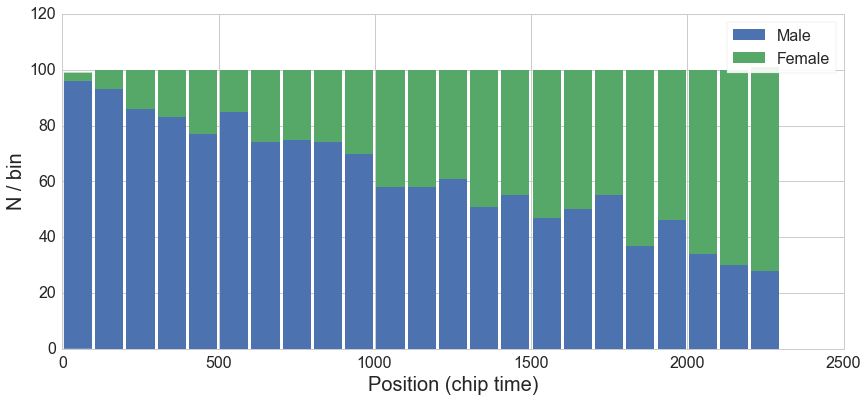

In [24]:
pos = 'chip_position'
nbins = 23
lw = 0
x_range = [0, 2300]
normed = False
n, bins, _ = plt.hist([df_male[pos].values, df_female[pos].values], 
                      bins=nbins, stacked=True, histtype='barstacked',
                      label=['Male', 'Female'], lw=lw, range=x_range, 
                      rwidth=0.9, normed=normed)
# Add in error bars:
# bin_centers = 0.5*(bins[1:]+bins[:-1])
# plt.bar(bin_centers, n[0], yerr=np.sqrt(n[0]), width=0, alpha=0, 
#         ecolor='black', error_kw=dict(elinewidth=2, capthick=2), 
#         label=r'Err = $\sqrt{N_{male}}$')
plt.xlabel('Position (chip time)')
plt.ylabel("N / bin")
plt.legend(loc=0)

In [34]:
df_male.chip_datetime

0      1900-01-01 01:12:39
1      1900-01-01 01:13:23
2      1900-01-01 01:13:59
3      1900-01-01 01:14:42
4      1900-01-01 01:17:08
5      1900-01-01 01:17:51
6      1900-01-01 01:18:12
7      1900-01-01 01:18:21
8      1900-01-01 01:18:58
9      1900-01-01 01:19:05
10     1900-01-01 01:20:01
12     1900-01-01 01:20:44
13     1900-01-01 01:21:00
14     1900-01-01 01:21:10
15     1900-01-01 01:21:20
16     1900-01-01 01:21:55
17     1900-01-01 01:22:29
18     1900-01-01 01:22:43
19     1900-01-01 01:22:51
20     1900-01-01 01:23:02
21     1900-01-01 01:23:04
22     1900-01-01 01:23:05
23     1900-01-01 01:24:12
24     1900-01-01 01:24:16
25     1900-01-01 01:24:17
26     1900-01-01 01:24:25
27     1900-01-01 01:24:31
28     1900-01-01 01:24:31
29     1900-01-01 01:24:38
30     1900-01-01 01:24:50
               ...        
2186   1900-01-01 02:40:44
2188   1900-01-01 02:40:54
2200   1900-01-01 02:43:11
2206   1900-01-01 02:43:39
2209   1900-01-01 02:44:15
2211   1900-01-01 02:44:35
2

So it's clear that, on average, men tend to finish in shorter times than women. Nothing revelatory there, but nice to see the strength of the correlation.

## Lining up 

One question we could ask is: do people tend to line up in the right places? Do people tend to be optimistic or pessimistic about their times? Of course, to answer this properly would involve knowing exactly where everyone started physically. This is information we don't possess. However, we can do something similar by comparing gun and chip times. The difference is related to how far back the person started. So our question now becomes: how does $\Delta(t_{Gun}, t_{Chip})$ relate to chip time (or equivalently chip position)?

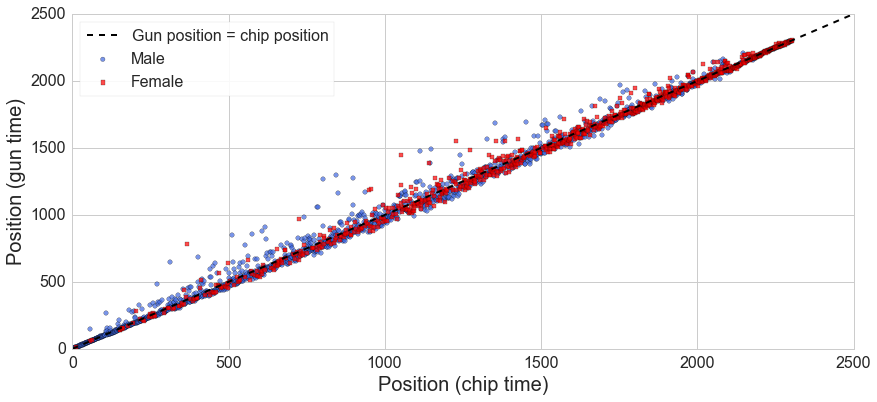

In [25]:
alpha = 0.7
plt.scatter(x=df_male.chip_position.values,
            y=df_male.gun_position.values, c='royalblue', alpha=alpha, label='Male')
plt.scatter(x=df_female.chip_position.values,
            y=df_female.gun_position.values, c='red', alpha=alpha, label='Female', marker='s')
plt.xlabel('Position (chip time)')
plt.ylabel('Position (gun time)')
plt.plot([0,2500], [0,2500], lw=2, c='black', ls='--', label='Gun position = chip position')
plt.xlim(0, 2500)
plt.ylim(0, 2500)
plt.legend(loc=0)

So for most people, their gun position is similar to their chip position. However there are some cases there the position according to gun time is much larger than according to chip time (above the diagonal). I guess these people got stuck further back than their 'proper' starting position, delaying their start across the line.

In [26]:
df[df.name.str.contains('Robin Aggleton')]

,category,status,name,gun_position,gun_datetime,chip_datetime,race_num,chip_position
695,Male Senior,RES,Robin Aggleton,680,1900-01-01 01:50:37,1900-01-01 01:49:29,17,696


In [27]:
df[(df.name.str.contains('David Thomas')) & (df.category.str.contains("Male Senior"))]

,category,status,name,gun_position,gun_datetime,chip_datetime,race_num,chip_position
1429,Male Senior,RES,David Thomas,1396,1900-01-01 02:07:48,1900-01-01 02:05:52,2339,1430


In [28]:
df[df.name.str.contains('Matthew Bluteau')]

,category,status,name,gun_position,gun_datetime,chip_datetime,race_num,chip_position
238,Male Senior,RES,Matthew Bluteau,233,1900-01-01 01:37:49,1900-01-01 01:37:26,214,239


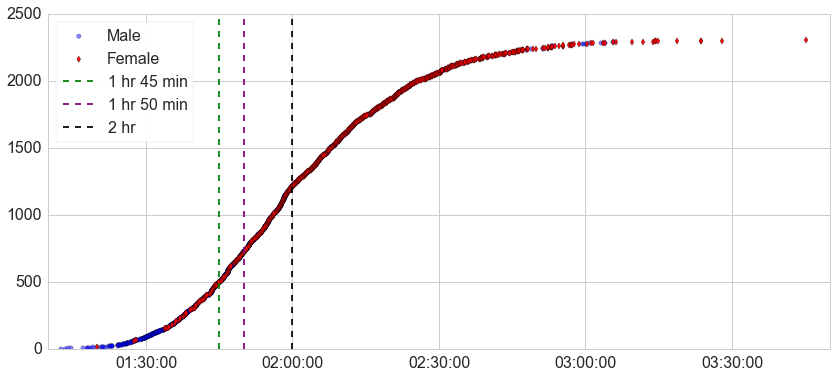

In [29]:
plt.scatter(x=df_male.chip_datetime.values, y=df_male.chip_position.values, 
            alpha=0.5, c='blue', label='Male')
plt.scatter(x=df_female.chip_datetime.values, y=df_female.chip_position.values, 
            alpha=0.95, c='red', label='Female', marker='d')
# plt.yscale('log')
plt.gca().get_xlim()
plt.xlim(mdates.date2num(datetime(1900, 1, 1, 1, 10, 0)), mdates.date2num(datetime(1900, 1, 1, 3, 50, 0)))
plt.ylim(0, 2500)
plt.legend(loc=0)
type(df.chip_datetime.values[0])
mdates.num2date(693596.04)
mdates.date2num(datetime(1900, 1, 1, 2, 0, 0))
plt.vlines(mdates.date2num(datetime(1900, 1, 1, 1, 45, 0)), *plt.ylim(), 
           linestyles='dashed', label="1 hr 45 min", color='green')
plt.vlines(mdates.date2num(datetime(1900, 1, 1, 1, 50, 0)), *plt.ylim(), 
           linestyles='dashed', label="1 hr 50 min", color='purple')
plt.vlines(mdates.date2num(datetime(1900, 1, 1, 2, 0, 0)), *plt.ylim(), 
           linestyles='dashed', label="2 hr")
plt.legend(loc=2)

In [30]:
dates = ['01/02/1991','01/03/1991','01/04/1991']
x = [datetime.strptime(d,'%m/%d/%Y').date() for d in dates]

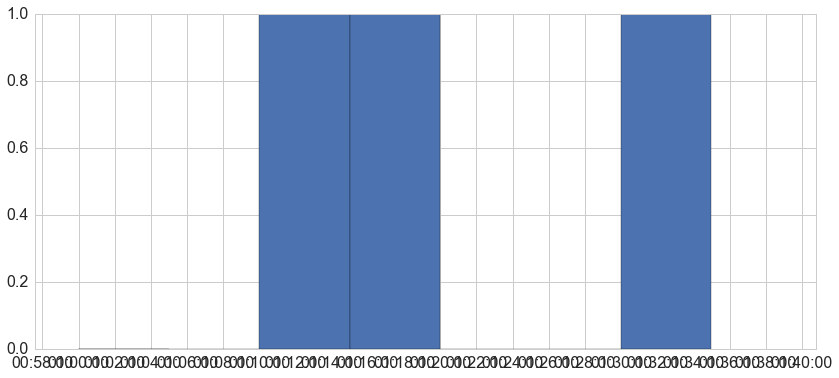

In [31]:
plt.hist([mdates.date2num(datetime.strptime('01:10:00', "%H:%M:%S")), 
          mdates.date2num(datetime.strptime('01:15:00', "%H:%M:%S")), 
          mdates.date2num(datetime.strptime('01:30:00', "%H:%M:%S"))], 
         bins=7, 
         range=[mdates.date2num(datetime.strptime('01:00:00', "%H:%M:%S")), 
                mdates.date2num(datetime.strptime('01:35:00', "%H:%M:%S"))])
plt.gca().xaxis.set_major_locator( mdates.MinuteLocator(interval=2) )
plt.gca().xaxis.set_major_formatter( mdates.DateFormatter("%H:%M:%S") )
